# Example code for data analysis

This ipython notebook, together with the main file in this repository, is an example created for helping the user familiarise with the code. In this notebook, the trajectories produced with the main file are processed and the evolution of the CQ state is represented in phase space.

The system under examination is a qubit system interacting with the classical degrees of freedom through the coupling Hamiltonian,

$H_I = q B \left( \omega_0 | 0 \rangle \langle 0 | + \omega_1 | 1 \rangle \langle 1 | \right)$.

The fully quantum Hamiltonian is,

$H_Q = \gamma \left( | 0 \rangle \langle 1 | + | 1 \rangle \langle 0 | \right)$.

The classical Hamiltonian is,

$H_C = \frac{p^2}{2 m}$.

The parameters of the simulation are (without unit of measure),

- $B = 1$
- $\omega_0 = - \omega_1 = 1$
- $\gamma = 10^{-4}$
- $m = 1$
- $\delta t = 2.5 \cdot 10^{-5}$ (time step)

## Stern Gerlach with diagonal Lindblad operators

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline

### Load the classical-quantum trajectories

Load the output files where the trajectories have been stored.

Each output file is a different trajectory of a quantum system in phase space.

The following items are stored in each file:

- $e_0$ : amplitude of $| 0 \rangle$
- $e_1$ : amplitude of $| 1 \rangle$
- $q$ : position in phase space
- $p$ : momentum in phase space
- $t$ : time step

In [2]:
traj_number = 200

quantum_trajectories = []
classic_trajectories = []

for it in range(traj_number):
        
    filename = './output/trajectory_{0}.dat'.format(it)
    quantum_trajectory = np.loadtxt(filename,
                                    skiprows = 4,
                                    delimiter = ' , ',
                                    usecols = (0,1),
                                    dtype = np.complex
                                   )
    classic_trajectory = np.loadtxt(filename,
                                    skiprows = 4,
                                    delimiter = ' , ',
                                    usecols = (2,3),
                                    dtype = np.float
                                   )
    quantum_trajectories.append(quantum_trajectory)
    classic_trajectories.append(classic_trajectory)
        
quantum_trajectories = np.array(quantum_trajectories)
classic_trajectories = np.array(classic_trajectories)

### Extract population and coherence

Compute the populations and the coherence of the quantum system,

- $u_0 = | e_0 |^2$ population of $| 0 \rangle$
- $u_1 = | e_1 |^2$ population of $| 1 \rangle$
- $c = | e_0 e^{\star}_1 |$ coherence of the quantum state

In [3]:
quantum_trajectories_u0 = np.absolute(quantum_trajectories[:,:,0])**2
quantum_trajectories_u1 = np.absolute(quantum_trajectories[:,:,1])**2
quantum_trajectories_coh = np.absolute(np.multiply(quantum_trajectories[:,:,0],np.conjugate(quantum_trajectories[:,:,1])))

Create the phase space grid,

In [4]:
qmax = 4e-3      # Maximum position in phase space
qdelta = 1e-4    # Spacing between position bins
pmax = 1.5e-1    # Maximum momentum in phase space
pdelta = 1e-2    # Spacing between momentum bins

tdelta = 2.5e-5

# Prepare the phasespace grid
q_values = np.arange(-qmax, qmax + qdelta, qdelta, dtype=np.float)
p_values = np.arange(-pmax, pmax + qdelta, pdelta, dtype=np.float)

Average over the different trajectories and fill the phase space at each time step,

**NOTE** : the double `for` loop in the following block is slow, and broadcasting the numpy array would be better (albeit more demanding in terms of memory). However, since broadcasting the arrays would make the code less clear, we decided to avoid it in this example.  

In [5]:
def traj_to_points(bin_index, quantum_traj, traj_number):
    pointarray = np.sum(np.multiply(bin_index,quantum_traj), axis=0)/float(traj_number)
    return pointarray.tolist()

In [6]:
phasespace_u0_evo = []
phasespace_u1_evo = []
phasespace_coh_evo = []

for p in p_values:
    row_u0 = []
    row_u1 = []
    row_coh = []
    
    for q in q_values:
        shift_coordinates = lambda point : point - np.array([q,p])
        shifted_traj = np.apply_along_axis(shift_coordinates,axis=2,arr=classic_trajectories)
        pos_mom_bins = np.absolute(shifted_traj) <= np.array([(qdelta/2.,pdelta/2.)])
        bin_index = pos_mom_bins.all(axis=2)
        
        row_u0.append(traj_to_points(bin_index, quantum_trajectories_u0, traj_number))
        row_u1.append(traj_to_points(bin_index, quantum_trajectories_u1, traj_number))
        row_coh.append(traj_to_points(bin_index, quantum_trajectories_coh, traj_number))
        
    phasespace_u0_evo.append(row_u0)
    phasespace_u1_evo.append(row_u1)
    phasespace_coh_evo.append(row_coh)
    
phasespace_u0_evo = np.array(phasespace_u0_evo)
phasespace_u1_evo = np.array(phasespace_u1_evo)
phasespace_coh_evo = np.array(phasespace_coh_evo)

### Plot the evolution of the populations in phase space

Contour plot of the population $u_0$ and $u_1$ at the following time step,

In [27]:
timestep = 1500
time = tdelta*timestep

Create the ticks for position and momentum,

In [28]:
x_max = 4e-3
x_delta = 2e-3
y_max = 1.5e-1
y_delta = 5e-2

xpos_tick = np.arange(-x_max,x_max+x_delta,x_delta)
ypos_tick = np.arange(-y_max,y_max+y_delta,y_delta)

Plot the data,

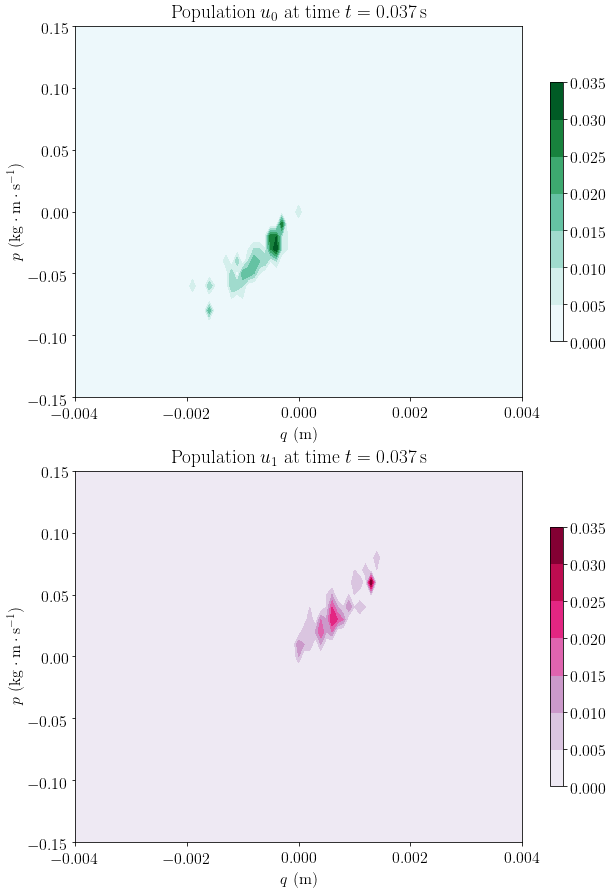

In [63]:
X, Y = np.meshgrid(q_values, p_values)

u0 = phasespace_u0_evo[:,:,timestep]
u1 = phasespace_u1_evo[:,:,timestep]

fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,15))

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size = 16)

# Contour plot for population u0
cont0 = ax0.contourf(X, Y, u0, cmap=cm.BuGn)
ax0.set_title('Population $u_0$ at time $t={0:.3f}$'.format(time) + '$\, \mathrm{s}$')
ax0.set_xlabel('$q \ (\mathrm{m})$')
ax0.set_ylabel('$p \ (\mathrm{kg \cdot m \cdot s^{-1}})$')
ax0.set_xticks(xpos_tick)
ax0.set_yticks(ypos_tick)
plt.colorbar(cont0, ax=ax0, shrink=0.7, format='%.3f')

# Contour plot for population u1
cont1 = ax1.contourf(X, Y, u1, cmap=cm.PuRd)
ax1.set_title('Population $u_1$ at time $t={0:.3f}$'.format(time) + '$\, \mathrm{s}$')
ax1.set_xlabel('$q \ (\mathrm{m})$')
ax1.set_ylabel('$p \ (\mathrm{kg \cdot m \cdot s^{-1}})$')
ax1.set_xticks(xpos_tick)
ax1.set_yticks(ypos_tick)
plt.colorbar(cont1, ax=ax1, shrink=0.7, format='%.3f')

### Average position and momentum in phase space

The evolution of the average position and momentum of the CQ state can be computed with the following function,

In [61]:
def mean_variance(u, mean, variance, values):
    norm = np.sum(u)
    mean_val = np.sum(u*values)/norm
    mean.append(np.absolute(mean_val))
    variance.append(np.sqrt(np.sum(u*(values-mean_val)**2)/norm))
    
def mean_variance_pos_mom(phasespace, q_values, p_values, final_time):
    
    mean_pos = []
    mean_mom = []
    variance_pos = []
    variance_mom = []
    
    for t in np.arange(final_time):
        
        u = phasespace[:,:,t]
        uq = np.sum(u,axis=0) # Compute marginals over position
        up = np.sum(u,axis=1) # Compute marginals over momentum

        # Mean value and variance for position and momentum
        mean_variance(uq, mean_pos, variance_pos, q_values)
        mean_variance(up, mean_mom, variance_mom, p_values)
    
    return mean_pos, variance_pos, mean_mom, variance_mom

Plots of the data,

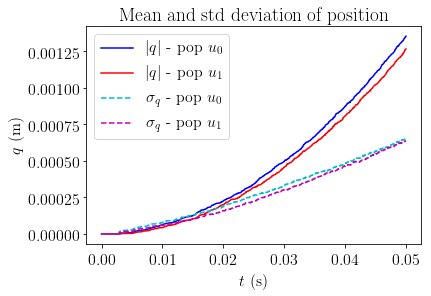

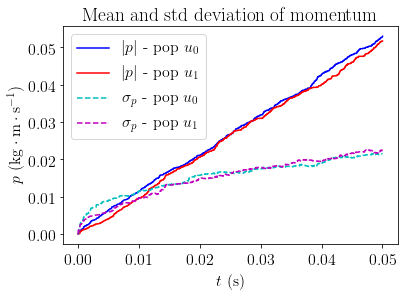

In [62]:
final_time = 2002

mean_pos_u0, variance_pos_u0, mean_mom_u0, variance_mom_u0 = mean_variance_pos_mom(phasespace_u0_evo, q_values, p_values, final_time)
mean_pos_u1, variance_pos_u1, mean_mom_u1, variance_mom_u1 = mean_variance_pos_mom(phasespace_u1_evo, q_values, p_values, final_time)
timeline = tdelta * np.arange(final_time)

# Plot the variace and mean of position
plt.figure()
plt.xlabel('$t \ (\mathrm{s})$')
plt.ylabel('$q \ (\mathrm{m})$')
plt.title('Mean and std deviation of position')
plt.plot(timeline, mean_pos_u0, 'b-', label='$|q|$ - pop $u_0$')
plt.plot(timeline, mean_pos_u1, 'r-', label='$|q|$ - pop $u_1$')
plt.plot(timeline, variance_pos_u0, 'c--', label='$\sigma_q$ - pop  $u_0$')
plt.plot(timeline, variance_pos_u1, 'm--', label='$\sigma_q$ - pop  $u_1$')
plt.legend()

# Plot the variace and mean of position
plt.figure()
plt.xlabel('$t \ (\mathrm{s})$')
plt.ylabel('$p \ (\mathrm{kg \cdot m \cdot s^{-1}})$')
plt.title('Mean and std deviation of momentum')
plt.plot(timeline, mean_mom_u0, 'b-', label='$|p|$ - pop $u_0$')
plt.plot(timeline, mean_mom_u1, 'r-', label='$|p|$ - pop $u_1$')
plt.plot(timeline, variance_mom_u0, 'c--', label='$\sigma_p$ - pop  $u_0$')
plt.plot(timeline, variance_mom_u1, 'm--', label='$\sigma_p$ - pop  $u_1$')
plt.legend()


### Coherence of the quantum state

The evolution of the coherence in the origin of the phase space is given by,

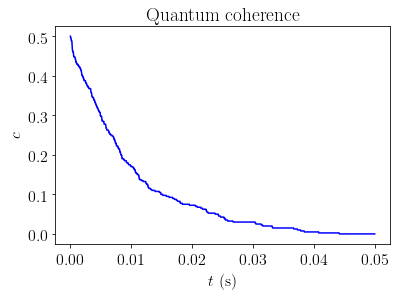

In [74]:
q_origin = int(q_values.size/2)
p_origin = int(p_values.size/2)

# Extract quantum coherence in the origin of phase space
coh_origin = phasespace_coh_evo[p_origin,q_origin,:]

plt.figure()
plt.xlabel('$t \ (\mathrm{s})$')
plt.ylabel('$c$')
plt.title('Quantum coherence')
plt.plot(timeline, coh_origin, 'b-')